# Student Lab, Strasbourg 2025

After learning about different data science concepts (scraping, visualization, data manipulation, machine learning..), you will now work on your own, on a workshop similar to the one presented

You should go through this notebook, and  fill in the code whenever you see `TODO:` written

Start by installing and importing the needed packages:

In [23]:
# TODO: Add other packages you need to install here
# !pip install requests beautifulsoup4

# Solution:
!pip install requests beautifulsoup4 pandas numpy plotly ipywidgets seaborn matplotlib adjustText scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [24]:
# TODO: Add any additional imports you need
# import requests
# from bs4 import BeautifulSoup

# Solution:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Scraping

We will once again be scraping data from the [understat.com](https://understat.com) website:

In [25]:
# Create a URL based on your choice of league and season
# TODO: Add your URL below
# url = "YOUR CODE HERE"

# Solution:
url = "https://understat.com/league/Serie_A/2023"

Run the next cell to see if your URL is valid:

In [26]:
try:
    if not url.startswith('https://understat.com/'):
        print("❌ URL must start with 'https://understat.com/'")
    else:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"✅ URL is valid: {url}")
        else:
            print(f"❌ URL is invalid: {url}")
except requests.exceptions.RequestException as e:
    print(f"❌ URL is invalid: {url}")

✅ URL is valid: https://understat.com/league/Serie_A/2023


We scrape the corresponding page just as seen in the workshop

In [27]:
res = requests.get(url)
soup = BeautifulSoup(res.content, "html.parser")
scripts = soup.find_all('script')
string_with_json_obj = ''
for script in scripts:
    if 'teamsData' in str(script):
        string_with_json_obj = str(script).strip()
ind_start = string_with_json_obj.index("('")+2
ind_end = string_with_json_obj.index("')")
json_data = string_with_json_obj[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

Create a DataFrame from the JSON data

In [28]:
rows = []
for team_id, team_data in data.items():
    for game in team_data['history']:
        row = {'team_name': team_data['title']}
        row.update(game)
        rows.append(row)
df = pd.DataFrame(rows)

# Check the data
df.sample(5)

,team_name,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
574,Torino,h,1.106780,1.107640,1.106780,1.107640,"{'att': 340, 'def': 22}","{'att': 191, 'def': 11}",2,6,1,1,1.3408,d,2023-09-24 18:45:00,0,1,0,1,-0.000860
66,Roma,h,0.858457,0.777601,0.858457,0.777601,"{'att': 184, 'def': 21}","{'att': 388, 'def': 20}",6,2,1,0,1.3805,w,2024-03-17 17:00:00,1,0,0,3,0.080856
467,Fiorentina,h,1.574350,2.310190,0.813049,1.548890,"{'att': 345, 'def': 31}","{'att': 153, 'def': 24}",8,2,2,1,0.8030,w,2023-11-12 14:00:00,1,0,0,3,-0.735841
332,Napoli,a,1.361480,1.379160,1.361480,1.379160,"{'att': 278, 'def': 9}","{'att': 250, 'def': 26}",8,3,1,1,1.3889,d,2024-03-17 19:45:00,0,1,0,1,-0.017680
367,Inter,h,2.918520,0.258264,2.066880,0.258264,"{'att': 216, 'def': 22}","{'att': 445, 'def': 27}",5,3,4,0,2.9148,w,2024-02-28 19:45:00,1,0,0,3,1.808616


## Data exploration

In this section, you'll create visualizations to explore the data you've scraped, in order to understand different relationships in the data.

In [29]:
# TODO: Convert 'date' to datetime and sort by date
# df['date'] = "YOUR CODE HERE"
# df = "YOUR CODE HERE"

# Solution:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [30]:
# TODO: Display the 'date' and 'result' of the first 5 matches of a team of your choice
# team_name = "YOUR CODE HERE"
# YOUR CODE HERE

# Solution:
team_name = "Juventus"
df_team = df[df['team_name'] == team_name]
df_team = df_team[['date', 'result']]
df_team = df_team.sort_values(by='date')
df_team.head(5)

,date,result
152,2023-08-20 18:45:00,w
153,2023-08-27 16:30:00,d
154,2023-09-03 18:45:00,w
155,2023-09-16 13:00:00,w
156,2023-09-23 16:00:00,l


In [31]:
# TODO: How many match was won at home, and how many away (accross all teams)? Can we deduce anything from this?
# YOUR CODE HERE

# Solution:
print("Home wins:", len(df[(df['h_a']=='h') & (df['result']=='w')]))
print("Away wins:", len(df[(df['h_a']=='a') & (df['result']=='w')]))
print("--> Teams win more often at home than away.")

Home wins: 159
Away wins: 109
--> Teams win more often at home than away.


In [32]:
# TODO: Who won the league? With how many points? (i.e. which team has the most points at the end of the season)
# TODO: Bonus: Can you display the table with the points of all teams sorted by points?
# YOUR CODE HERE

# Solution:
df_pts = df.groupby('team_name').agg({'pts': 'sum'}).sort_values(by='pts', ascending=False)
print(f"League winner: {df_pts.index[0]} with {df_pts.iloc[0]['pts']} points")
df_pts

League winner: Inter with 94 points


,pts
team_name,
Inter,94
AC Milan,75
Juventus,71
Atalanta,69
Bologna,68
Roma,63
Lazio,61
Fiorentina,60
Torino,53


## Preprocessing

In this section, you'll prepare the data in order to answer the following question:

> Can we predict match results using advanced metrics like Expected Goals (xG)?


Meaning that unlike the previous workshop, we'll prepare our data for a **classification model** this time, in order to predict match outcomes (Win, Loss, or Draw) based on various metrics like xG, xGA, and others.

The general steps for preprocessing will be:
1. Handle categorical features  
2. Select relevant features
3. Split into training and testing sets
4. Scale the features

In [33]:
# Create a copy of the DataFrame for our classification task to avoid modifying the original
df_class = df.copy()

In [34]:
# TODO: Handle categorical features
# 1. Convert 'h_a' to numeric (1 for home, 0 for away)
# 2. Convert 'result' to numeric (1 for win, 0 for draw, -1 for loss)
# df_class['h_a'] = "YOUR CODE HERE"
# df_class['result'] = "YOUR CODE HERE"

# Solution:
df_class['h_a'] = df_class['h_a'].map({'h': 1, 'a': 0})
df_class['result'] = df_class['result'].map({'w': 1, 'd': 0, 'l': -1})

In [35]:
# TODO: Select features for your classification model
# Think about which metrics might be most predictive of match outcomes (is the date important?)
# features = ["YOUR", "CODE", "HERE"]
# X = "YOUR CODE HERE"
# y = "YOUR CODE HERE"

# Solution:
features = ['h_a', 'xG', 'xGA', 'npxG', 'npxG', 'deep', 'deep_allowed']
X = df_class[features]
y = df_class['result']

In [36]:
# TODO: Split the data into training (85%) and testing (15%) sets
# 1. Use train_test_split from sklearn
# 2. The test size should be 15% of the data
# 3. Use stratify to ensure the same proportion of classes in both sets
# X_train, X_test, y_train, y_test = "YOUR CODE HERE"

# Solution:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [37]:
# TODO: Scale your features using StandardScaler (make sure to fit the scaler on the training data only, but transform both)
# scaler = "YOUR CODE HERE"
# X_train_scaled = "YOUR CODE HERE"
# X_test_scaled = "YOUR CODE HERE"

# Solution:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Predicting

You will now train and test a **Classifier** model (unlike the **regression** model previously used)

In [38]:
# TODO: Train your selected model on the training data
# YOUR CODE HERE

# Solution:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# TODO: Make predictions on the test set
y_pred = "YOUR CODE HERE"

# Solution:
y_pred = classifier.predict(X_test_scaled)

In [40]:
# TODO: Calculate the accuracy score of your model
accuracy = "YOUR CODE HERE"

# Solution:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4737


In [41]:
# TODO: Generate classification report to better understand the model's performance
# report  = "YOUR CODE HERE"
# print(report)

# Solution:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.52      0.55      0.54        40
           0       0.32      0.32      0.32        34
           1       0.55      0.53      0.54        40

    accuracy                           0.47       114
   macro avg       0.47      0.47      0.47       114
weighted avg       0.47      0.47      0.47       114



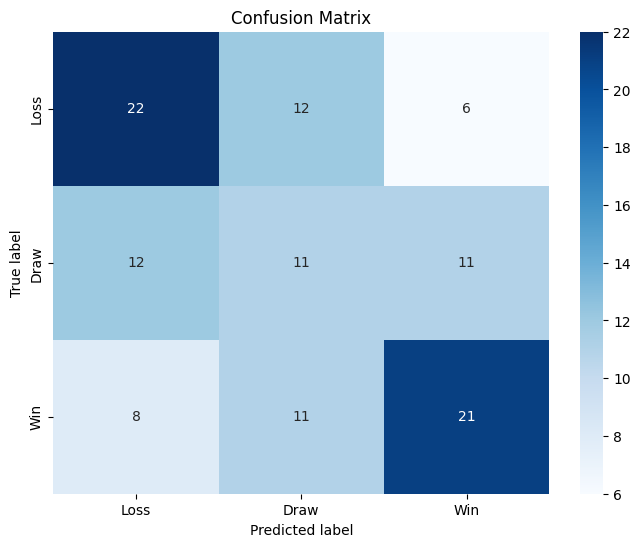

In [42]:
# TODO: Create a confusion matrix heatmap (using sns) to visualize the model's performance
# YOUR CODE HERE

# Solution:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# TODO: use the feature_importances_ attribute of the classifier to analyse the importance of each feature in the model
# YOUR CODE HERE

# Solution:
features = X.columns
importances = classifier.feature_importances_
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

h_a: 0.0313
xG: 0.1934
xGA: 0.2424
npxG: 0.1616
npxG: 0.1544
deep: 0.1067
deep_allowed: 0.1103


## Bonus Challenge: Predicting Over/Under Goals

As a bonus challenge, create a model to predict whether a match will have over or under a certain number of goals (e.g., over/under 2.5 goals). This is a common betting market in football.

Steps:
1. Create a new target variable for over/under 2.5 goals
2. Preprocess the data as before
3. Train a model and evaluate its performance
4. Compare its accuracy to the previous match outcome prediction model

In [44]:
# Create a new DataFrame for the over/under prediction task
df_over_under = df.copy()

# TODO: Create target variable (1 for over 2.5 goals, 0 for under 2.5 goals)
# Your code here

# TODO: Process features, split data, and train a classifier
# Your code here

# TODO: Evaluate model performance
# Your code here

# Thank you for your participation!